<a href="https://colab.research.google.com/github/Jordan-Ireland/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

It may be helpful to use PCA to reduce the dimensions of your data first in order to obtain --but then again, maybe not. I dunno, you're the data scientist, you tell me.🤪 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this
from scipy.spatial import distance

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [52]:
df = df.drop('diagnosis', axis=1)
df = df.drop('Unnamed: 32', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# You take it from here!

See what you can come up with. You have all the know-how! 

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to do PCA on this data to see if that helps you find distinct linearly-separable clusters.
  - (In the real world, truly linearly-separable clusters are rare.)
- You might want to use an elbow chart to decide on the number of clusters to use.
- You might want to use a scree plot to decide how many principal components to include in your clustering.
- You might want to standardize your data before PCA (If you decide to use PCA). 

## Manage your time and don't spend it all on data exploration or something like that. You got this!

In [53]:
df.isna().sum() 

id                         0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [54]:
df.dtypes

id                           int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [0]:
##### Your Code Here #####

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

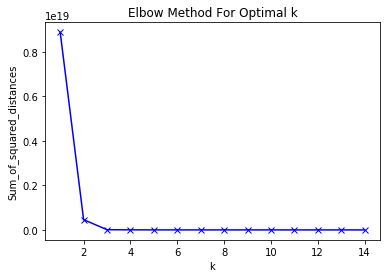

In [56]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

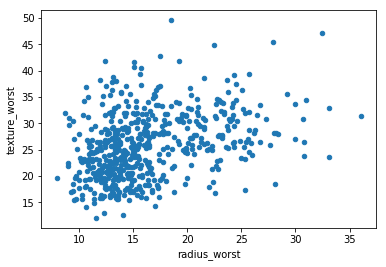

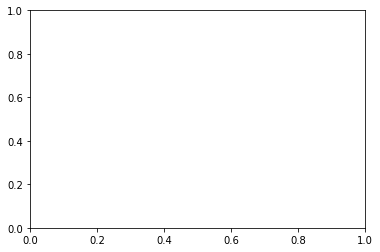

In [57]:
# Create scatterplot with coloring based on assigned labels
colors = {0:'red', 1:'blue'}
df.plot(x='radius_worst',y='texture_worst', kind='scatter')
plt.show()  
fig, ax = plt.subplots()

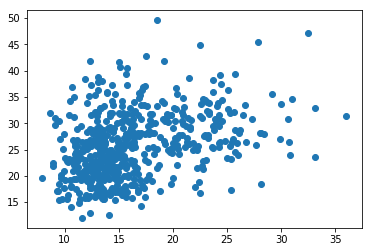

In [58]:
data = pd.DataFrame([df['radius_worst'],df['texture_worst']]).T
data.head()

plt.scatter(data.radius_worst, data.texture_worst)
plt.show()

In [59]:
dataset_centroid_x = data.radius_worst.mean()
dataset_centroid_y = data.texture_worst.mean()

print(dataset_centroid_x, dataset_centroid_y)

16.269189806678394 25.677223198594014


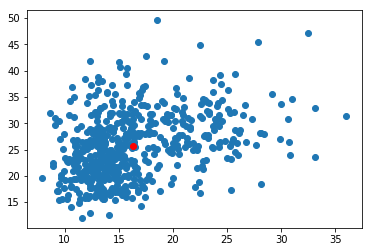

In [60]:
ax.plot(data.radius_worst, data.texture_worst)
ax = plt.subplot(1,1,1)
ax.scatter(data.radius_worst, data.texture_worst)
ax.plot(dataset_centroid_x, dataset_centroid_y, "or")
plt.show()

In [61]:
centroids = data.sample(2)
centroids.head()

,radius_worst,texture_worst
310,12.61,26.55
420,13.07,26.98


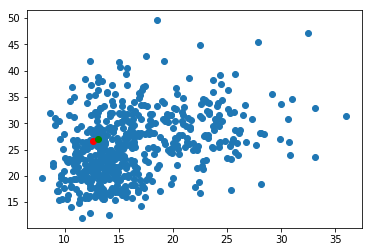

In [62]:
ax = plt.subplot(1,1,1)
ax.scatter(data.radius_worst, data.texture_worst)
ax.plot(centroids.iloc[0].radius_worst, centroids.iloc[0].texture_worst, "or")
ax.plot(centroids.iloc[1].radius_worst, centroids.iloc[1].texture_worst, "og")
plt.show()

In [46]:

def get_centroids(d, centroids,it):
  distances = distance.cdist(d,centroids,'euclidean')
  nearest = np.argmin(distances,axis=1)
  se = pd.Series(nearest)
  data['cluster_'+it] = se.values
  
  return data

first_pass = get_centroids(data, centroids, '1')
first_pass.head()

,radius_worst,texture_worst,cluster_1
0,25.38,17.33,1
1,24.99,23.41,1
2,23.57,25.53,1
3,14.91,26.50,0
4,22.54,16.67,1


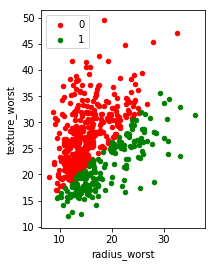

In [48]:
def plot_clusters(d, column_header, centroids):
  colors = {0:'red', 1:'green', 2:'magenta'}
  fig, ax = plt.subplots()
  ax.plot(centroids.iloc[0].radius_worst, centroids.iloc[0].texture_worst, "or")
  ax.plot(centroids.iloc[1].radius_worst, centroids.iloc[1].texture_worst, "og")
  ax.set_aspect('equal')
  grouped = d.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='radius_worst', y='texture_worst', label=key, color=colors[key])
  plt.show()
  
plot_clusters(first_pass, 'cluster_1', centroids)

In [63]:
def find_nearest_centroid(df, centroids):
  last_centroids = [np.random.choice([0,1,2])] * df.shape[0]
  df_temp = df.copy()
  i = 0
  
  while True:
    if i>0:
      centroids = get_centroids(df_temp, 'cluster' + str(i-1))

    distances = distance.cdist(df_temp[['radius_worst', 'texture_worst']], centroids[['radius_worst', 'texture_worst']])
    nearest_centroids = np.argmin(distances, axis=1)
    
    df_temp['cluster' + str(i)] = nearest_centroids
    
    if (list(nearest_centroids) == list(last_centroids)):
      return df_temp
    else:
      i +=1
      last_centroids = nearest_centroids
      
def get_centroids(df, column_header):
  x = [df.radius_worst.mean(), df.radius_worst.mean()]
  y = [df.texture_worst.mean(), df.texture_worst.mean()]
  data = {'radius_worst': x, 'texture_worst' : y}
  return pd.DataFrame(data)
  
  
find_nearest_centroid(data, centroids).head()

,radius_worst,texture_worst,cluster0,cluster1,cluster2
0,25.38,17.33,1,0,0
1,24.99,23.41,1,0,0
2,23.57,25.53,1,0,0
3,14.91,26.50,1,0,0
4,22.54,16.67,1,0,0


# Stretch Goal:

Once you are satisfied with your clustering, go back and add back in the labels from the original dataset to check how accurate your clustering was. Remember that this will not be a possibility in true unsupervised learning, but it might be a helpful for your learning to be able to check your work against the "ground truth". Try different approaches and see which one is the most successful and try understand why that might be the case. If you go back and try different methods don't ever include the actual "diagnosis" labels in your clustering or PCA.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.